# Chlorophyll A Data Vis Workbook

### Imports

In [2]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Load & Format BGC Data

In [160]:
bgc_df = pd.read_csv("data/argo-isosurface-data.csv")
bgc_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
bgc_df.dropna(inplace=True) # Drop points missing chlorophyll values
bgc_df.drop_duplicates(inplace=True) # Drop duplicates (for some reason stations 1-9 like to duplicate)
bgc_df["Station Num"]=range(1,len(bgc_df)+1) # Add in column with station numbers
chl_a = "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0"
bgc_df[chl_a]=bgc_df[chl_a]/20. # Normalize chlorophyll data

bgc_df["Overall Day Num"] = bgc_df["Time [yr]"].astype(int) * 365 + bgc_df["Day of Year"] # Add in column with total days
bgc_df.head()

,Cruise,QV:ARGO,Station,QV:ARGO.1,Type,QV:ARGO.2,yyyy-mm-ddThh:mm:ss.sss,QV:ARGO.3,Longitude [degrees_east],QV:ARGO.4,...,QV:ARGO.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0,Station Num,Overall Day Num
1,5905108,0,1a_D_A_bio,0,C,0,2017-07-29T20:01:50,0,185.24200,0,...,0,1,0,185.242,-32.465,2017.57,210,0.598395,1,736415
3,5905108,0,2a_D_A_bio,0,C,0,2017-08-08T20:37:00,0,185.30000,0,...,0,1,0,185.300,-32.267,2017.60,220,0.628195,2,736425
5,5905108,0,3a_D_A_bio,0,C,0,2017-08-18T19:37:50,0,185.25600,0,...,0,1,0,185.256,-32.298,2017.63,230,0.415292,3,736435
7,5905108,0,4a_D_A_bio,0,C,0,2017-08-28T21:43:20,0,185.32600,0,...,0,1,0,185.326,-32.560,2017.66,240,0.514820,4,736445
9,5905108,0,5a_D_A_bio,0,C,0,2017-09-07T23:10:00,0,185.25101,0,...,0,1,0,185.251,-32.979,2017.68,250,0.363909,5,736455


### Load & Format Satellite Data

In [44]:
sat_data_dir = "data/satellite-data"

In [161]:
# Helper Functions
def loadSatelliteData(sat_data_dir):
    """Wrapper function for loading satellite data
    
    Args:
        sat_data_dir (str): string representing file location of all satellite data
    
    Returns:
        sat_df (DataFrame): pandas dataframe containing clean satellite data with chlA values
    """
    sat_df = pd.DataFrame()
    
    for f in glob.glob('%s/*.txt' % sat_data_dir): # Iterate through files in sat_data_dir
        year, day = parseFilenameDate(f)
        new_df = pd.read_csv(f, delimiter="\t",header=1)
        new_df["Time [yr]"] = int(year) # Add year to dataframe
        new_df["Day of Year"] = int(day) # Add day of year to dataframe
        sat_df = pd.concat([new_df, sat_df])
    
    sat_df.dropna(axis=1, how='all', inplace=True) #Remove unused columns
    sat_df.dropna(inplace=True) #Drop points missing chlorophyll values
    sat_df["Overall Day Num"] = sat_df["Time [yr]"].astype(int) * 365 + sat_df["Day of Year"] # Add in column with total days
    
    return sat_df

def parseFilenameDate(filename):
    """Parses satellite data filename for start date
    
    Args:
        filename (str): string representing filename
        
    Returns:
        year (int): year of data
        day (int): day of year of data
    """
    start_idx = filename.find("\V") + 2 #Each date starts with \V, and add 2 to move cursor over by /V
    year = filename[start_idx:start_idx + 4] #Year is 4 characters long 
    day = filename[start_idx + 4:start_idx + 7] #Day of year is 3 characters long

    return year, day

In [162]:
sat_df = loadSatelliteData(sat_data_dir)

In [163]:
sat_df.head()

,Cruise,QF,Station,QF.1,Type,QF.2,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first,Overall Day Num
0,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,1,1,B,1,1,180.02083,1,-20.02083,1,1,0,-179.979,-20.0208,2017,249,0.076766,736454
1,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,2,1,B,1,1,180.27083,1,-20.02083,1,1,0,-179.729,-20.0208,2017,249,0.074067,736454
2,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,3,1,B,1,1,180.52083,1,-20.02083,1,1,0,-179.479,-20.0208,2017,249,0.067281,736454
3,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,4,1,B,1,1,180.77083,1,-20.02083,1,1,0,-179.229,-20.0208,2017,249,0.063319,736454
4,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,5,1,B,1,1,181.02083,1,-20.02083,1,1,0,-178.979,-20.0208,2017,249,0.072604,736454


### Lookup Chl-A values
For each station in the BGC argo dataset, look up the nearest lat/long value within correct time period containing Chl-A data in the satellite dataset. Then create dataset to be plotted

In [165]:
# Nearest lat/long lookup

lats = sat_df["Latitude [degrees_north]"]

lat = -30.3
long = 173

nearest_lat_error = abs(lats-lat).min() # Compute error for nearest latitude point
nearest_lat_idxs = abs(lats-lat) == nearest_lat_error # Create bool array where latitude matches
lat_sat_df = sat_df[nearest_lat_idxs] # Use bool array to filter for matching latitude

longs = lat_sat_df["Longitude [degrees_east]"] # Only look at longitude
nearest_long_error = abs(longs-long).min()
nearest_long_idxs = abs(longs-long) == nearest_long_error

nearest_pts = lat_sat_df[nearest_long_idxs]
nearest_pts
# nearest_long_idx.nonzero()

,Cruise,QF,Station,QF.1,Type,QF.2,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first,Overall Day Num
60452,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,60453,1,B,1,1,173.02084,1,-30.27083,1,1,0,173.021,-30.2708,2017,249,0.169929,736454
60452,V20172332017240.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,60453,1,B,1,1,173.02084,1,-30.27083,1,1,0,173.021,-30.2708,2017,233,0.167886,736438
60452,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,60453,1,B,1,1,173.02084,1,-30.27083,1,1,0,173.021,-30.2708,2017,225,0.168409,736430


In [166]:
# Timeframe lookup
day_num = 736454 # want to get nearest day but not larger

chl_a_sat = "chlor_a [mg m^-3] @ Dummy=first"
nearest_pt = nearest_pts[nearest_pts["Overall Day Num"] - day_num >=0].min()
# nearest_pt = year_pts[year_pts["Day of Year"] - day >= 0].min()
nearest_pt_value = nearest_pt[chl_a_sat]

# nearest_pts["Time [yr]"] == str(time)


# nearest_pts["Time [yr]"] == "2017"
# # print(nearest_pts)
# a = nearest_pts["Time [yr]"]
# a = a.astype(int)


# a==2017
# if len(nearest_pt.dropna())==0: # Check to see if there are no valid day values  - means that data should be from previous year
#     year_pts = nearest_pts[nearest_pts["Time [yr]"] == time-1]
#     nearest_pt = year_pts[year_pts["Day of Year"]].max() ## DEBUG THIS LINE
#     nearest_pt_value = nearest_pt[chl_a_sat]
#     print(nearest_pt_value)
    
print(nearest_pt_value)

0.169929


In [ ]:
"""
sort by time, then find nearest day of year that's less than day value

if no value less than day value:
    get time from previous year and get largest day of year.

"""

In [ ]:
# Helper functions
def findNearestPt(x, y, xs, ys):
    """ Find approximate nearest point - finds nearest x first, then finds nearest y
    
    Args:
        x (float): x coordinate to approximate
        y (float): y coordinate to approximate
        xs (ndarray): numpy array of x coordinates
        ys (ndarray): numpy array of y coordinates
    """

    
#     nearest_x = abs(xs-x).min()
# return index

In [198]:
compiled_df = pd.DataFrame(columns=["Station Num", "BGC Lat", "BGC Long", "BGC Chl-A", "Sat Chl-A"])

# compiled_df = compiled_df.append({"Station Num": 3, "BGC Lat":2, "BGC Long":1, "BGC Chl-A":1, "Sat Chl-A":2}, ignore_index=True)
# compiled_df = compiled_df.append({"Station Num": 3, "BGC Lat":2, "BGC Long":1, "BGC Chl-A":1, "Sat Chl-A":3}, ignore_index=True)
# compiled_df

# compiled_df["Station Num"]=range(0,100)
# compiled_df["BGC Lat"]=range(1,101)
# compiled_df

,Station Num,BGC Lat,BGC Long,BGC Chl-A,Sat Chl-A
0,0,1,NaN,NaN,NaN
1,1,2,NaN,NaN,NaN
2,2,3,NaN,NaN,NaN
3,3,4,NaN,NaN,NaN
4,4,5,NaN,NaN,NaN
5,5,6,NaN,NaN,NaN
6,6,7,NaN,NaN,NaN
7,7,8,NaN,NaN,NaN
8,8,9,NaN,NaN,NaN
9,9,10,NaN,NaN,NaN


In [4]:
# df.iloc[3]

In [28]:
len(df["Longitude"])

200

In [29]:
len(df["Longitude"].unique())

93

In [38]:
len(df["Latitude"].unique())

93

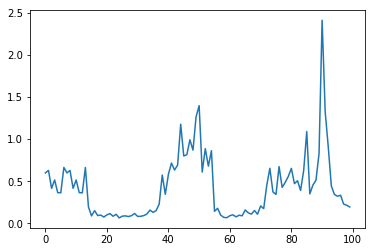

In [109]:
test = df["Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0"]
test2 = test.dropna()
a = range(len(test2))
#plt.plot(a, test2/20)

graph1 = plt.subplot()

graph1.plot(a, test2/20)

In [106]:
graph1.l

AttributeError: 'function' object has no attribute 'plot'

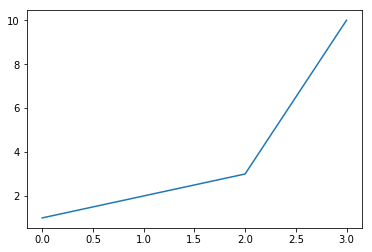

In [62]:
b = [1,2,3,10]
plt.plot(b)

In [32]:
import numpy as np

In [36]:
a = np.array([1,1,1])

In [37]:
a.drop_na()

AttributeError: 'numpy.ndarray' object has no attribute 'drop_na'

In [133]:
def findNearestPt(x, y, xs, ys):
    """ Find approximate nearest point - finds nearest x first, then finds nearest y
    
    Args:
        x (float): x coordinate to approximate
        y (float): y coordinate to approximate
        xs (ndarray): numpy array of x coordinates
        ys (ndarray): numpy array of y coordinates
    """

    
    nearest_x = abs(xs-x).min()

In [135]:
xs = np.array([1,1,2,2,3,3,4,4])
ys = np.array([1,3,1,3,1,3,1,3])
findNearestPt(1.2,1.3,xs, ys)

In [111]:
xs = np.array([1,1,2,2,3,3,4,4])

In [122]:
error = abs(xs-3)
error

array([2, 2, 1, 1, 0, 0, 1, 1])

In [123]:
idxs = error==error.min()

In [128]:
idxs

array([False, False, False, False,  True,  True, False, False], dtype=bool)

In [129]:
idxs.nonzero()

(array([4, 5], dtype=int64),)

In [ ]:
"""
for filename in glob directory

open csv file 
filename parse into dates
"""

In [140]:
scipy.datetime64()

numpy.datetime64('NaT')

In [143]:
scipy.datetime_as_string(100)

TypeError: input must have type NumPy datetime

In [151]:
np.datetime64(43893.00)

ValueError: Could not convert object to NumPy datetime

In [174]:
date_test = np.datetime64(4.2)

ValueError: Could not convert object to NumPy datetime

In [164]:
date_test

numpy.datetime64('4389300')

In [175]:
.57*365

208.04999999999998

In [ ]:
"""
Handling dates
- argo Time[yr] as int for year 
- argo day of year as int for day 
for each point in argo dataset:
    findSatCSV(year, day, filenames)
    
Satellite filenames: year, start date 
Need function to compute 
    

"""

In [203]:
df = pandas.read_csv("data/V20172252017232.test-sat.txt", delimiter="\t",header=1)

In [204]:
df

,Cruise,QF,Station,QF.1,Type,QF.2,yyyy-mm-ddThh:mm:ss.sss,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first
0,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,1,1,B,1,NaN,1,180.02083,1,-20.02083,1,1,0,-179.979,-20.0208,NaN,NaN,0.124504
1,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,2,1,B,1,NaN,1,180.27083,1,-20.02083,1,1,0,-179.729,-20.0208,NaN,NaN,0.086877
2,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,3,1,B,1,NaN,1,180.52083,1,-20.02083,1,1,0,-179.479,-20.0208,NaN,NaN,0.114178
3,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,4,1,B,1,NaN,1,180.77083,1,-20.02083,1,1,0,-179.229,-20.0208,NaN,NaN,NaN
4,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,5,1,B,1,NaN,1,181.02083,1,-20.02083,1,1,0,-178.979,-20.0208,NaN,NaN,NaN
5,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,6,1,B,1,NaN,1,181.27083,1,-20.02083,1,1,0,-178.729,-20.0208,NaN,NaN,0.072131
6,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,7,1,B,1,NaN,1,181.52083,1,-20.02083,1,1,0,-178.479,-20.0208,NaN,NaN,0.075288
7,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,8,1,B,1,NaN,1,181.77083,1,-20.02083,1,1,0,-178.229,-20.0208,NaN,NaN,0.091221
8,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,9,1,B,1,NaN,1,182.02083,1,-20.02083,1,1,0,-177.979,-20.0208,NaN,NaN,0.091708
9,V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,10,1,B,1,NaN,1,182.27083,1,-20.02083,1,1,0,-177.729,-20.0208,NaN,NaN,0.083765


TypeError: 'module' object is not callable

In [243]:
def parseFilenameDate(filename):
    """Parses satellite data filename for start date
    
    Args:
        filename (str): string representing filename
        
    Returns:
        year (int): year of data
        day (int): day of year of data
    """
    start_idx = f.find("\V") + 2 #Each date starts with \V, and add 2 to move cursor over by /V
    year = f[start_idx:start_idx + 4] #Year is 4 characters long 
    day = f[start_idx + 4:start_idx + 7] #Day of year is 3 characters long

    return year, day

In [248]:
sat_data_dir = "data/satellite-data"
# a = None
for f in glob.glob('%s/*.txt' % sat_data_dir):
    print(f)
    year, day = parseFilenameDate(f)
    df = pandas.read_csv("data/V20172252017232.test-sat.txt", delimiter="\t",header=1)
    print(year,day)
#     #a = pandas.read_csv(f, delimiter="\t",header=1)
    
# a.find("\V")
# a[21 + 6]
# year = a[21:21+4]
# year

data/satellite-data\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a_isosurface_data.txt
2017 225
data/satellite-data\V20172332017240.L3m_8D_SNPP_CHL.x_chlor_a_isosurface_data.txt
2017 233
data/satellite-data\V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a_isosurface_data.txt
2017 249


In [256]:
df1 = pd.DataFrame([1,2,3,4])
df2 = pd.DataFrame([1,2,3,2])

In [263]:
pd.concat([df1, df2])

,0
0,1
1,2
2,3
3,4
0,1
1,2
2,3
3,2


In [260]:
df3

,0
0,0 0 1 1 2 2 3 3 4
1,0 0 1 1 2 2 3 3 2


In [261]:
df1

,0
0,1
1,2
2,3
3,4


In [270]:
sat_data_dir = "data/satellite-data"
sat_df = pd.DataFrame()

for f in glob.glob('%s/*.txt' % sat_data_dir):
    year, day = parseFilenameDate(f)
    new_df = pd.read_csv(f, delimiter="\t",header=1)
    new_df["Time [yr]"] = year #Add year to dataframe
    new_df["Day of Year"] = day #Add day of year to dataframe
    sat_df = pd.concat([new_df, sat_df])
    
    #TODO: remove NA values
    
#    print(year,day)
#     #a = pandas.read_csv(f, delimiter="\t",header=1)
    
# a.find("\V")
# a[21 + 6]
# year = a[21:21+4]
# year

In [271]:
sat_df

,Cruise,QF,Station,QF.1,Type,QF.2,yyyy-mm-ddThh:mm:ss.sss,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first
0,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,1,1,B,1,NaN,1,180.02083,1,-20.02083,1,1,0,-179.979,-20.0208,2017,249,0.076766
1,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,2,1,B,1,NaN,1,180.27083,1,-20.02083,1,1,0,-179.729,-20.0208,2017,249,0.074067
2,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,3,1,B,1,NaN,1,180.52083,1,-20.02083,1,1,0,-179.479,-20.0208,2017,249,0.067281
3,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,4,1,B,1,NaN,1,180.77083,1,-20.02083,1,1,0,-179.229,-20.0208,2017,249,0.063319
4,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,5,1,B,1,NaN,1,181.02083,1,-20.02083,1,1,0,-178.979,-20.0208,2017,249,0.072604
5,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,6,1,B,1,NaN,1,181.27083,1,-20.02083,1,1,0,-178.729,-20.0208,2017,249,0.067157
6,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,7,1,B,1,NaN,1,181.52083,1,-20.02083,1,1,0,-178.479,-20.0208,2017,249,NaN
7,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,8,1,B,1,NaN,1,181.77083,1,-20.02083,1,1,0,-178.229,-20.0208,2017,249,0.059108
8,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,9,1,B,1,NaN,1,182.02083,1,-20.02083,1,1,0,-177.979,-20.0208,2017,249,0.048375
9,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,10,1,B,1,NaN,1,182.27083,1,-20.02083,1,1,0,-177.729,-20.0208,2017,249,0.064078


In [276]:
sat_df.dropna(axis="chlor_a [mg m^-3] @ Dummy=first")

ValueError: No axis named chlor_a [mg m^-3] @ Dummy=first for object type <class 'pandas.core.frame.DataFrame'>

In [301]:
sat_df.axes[1][18]

'chlor_a [mg m^-3] @ Dummy=first'

In [303]:
sat_df.dropna(axis=[sat_df.axes[1][18]])

ValueError: No axis named chlor_a [mg m^-3] @ Dummy=first for object type <class 'pandas.core.frame.DataFrame'>

In [306]:
sat_df.dropna(axis=1, how='all', inplace=True) #Remove unnecessary columns
sat_df.dropna(inplace=True) #Drop points missing chlorophyll values

In [307]:
sat_df

,Cruise,QF,Station,QF.1,Type,QF.2,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first
0,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,1,1,B,1,1,180.02083,1,-20.02083,1,1,0,-179.9790,-20.0208,2017,249,0.076766
1,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,2,1,B,1,1,180.27083,1,-20.02083,1,1,0,-179.7290,-20.0208,2017,249,0.074067
2,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,3,1,B,1,1,180.52083,1,-20.02083,1,1,0,-179.4790,-20.0208,2017,249,0.067281
3,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,4,1,B,1,1,180.77083,1,-20.02083,1,1,0,-179.2290,-20.0208,2017,249,0.063319
4,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,5,1,B,1,1,181.02083,1,-20.02083,1,1,0,-178.9790,-20.0208,2017,249,0.072604
5,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,6,1,B,1,1,181.27083,1,-20.02083,1,1,0,-178.7290,-20.0208,2017,249,0.067157
7,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,8,1,B,1,1,181.77083,1,-20.02083,1,1,0,-178.2290,-20.0208,2017,249,0.059108
8,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,9,1,B,1,1,182.02083,1,-20.02083,1,1,0,-177.9790,-20.0208,2017,249,0.048375
9,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,10,1,B,1,1,182.27083,1,-20.02083,1,1,0,-177.7290,-20.0208,2017,249,0.064078
10,V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,11,1,B,1,1,182.52083,1,-20.02083,1,1,0,-177.4790,-20.0208,2017,249,0.069896
